In [11]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

import os
import glob

import matplotlib

In [12]:
# Define the folder path
folder_path = "measurements\\measurements_after_HWP_fm2\\"
folder_path = "measurements/measurements_after_HWP_fm2/"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
csv_files

['measurements/measurements_after_HWP_fm2\\measured_darkcount.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rf02.csv',
 'measurements/measurements_after_HWP_fm2\\measured_rftest.csv']

In [13]:
# Print the names of the CSV files
for file in csv_files:
    print(os.path.basename(file))
    if 'rf' in os.path.basename(file):
       rf = os.path.basename(file).split('rf')[1][0:2]
    #    rf = int(rf)
       print('retrieved rf setting' , rf)

measured_darkcount.csv
measured_rf02.csv
retrieved rf setting 02
measured_rftest.csv
retrieved rf setting te


In [14]:
#read in darkcounts
darkcounts = pd.read_csv(csv_files[0])

In [15]:
# save all for all measured rfs the loaded df into a list
all_rf = [pd.read_csv(file) for file in csv_files[1:]]

# Optionally, print the first few rows of each DataFrame
# for i, df in enumerate(all_rf):
#     print(f"Data from {os.path.basename(csv_files[i])}:")
#     print(df.head())  # Show the first 5 rows of each CSV file
#     print("\n")

In [16]:
cmap = matplotlib.colormaps['Purples']

# Take colors at regular intervals spanning the colormap
colors = cmap(np.linspace(1, 0, len(csv_files)-1))

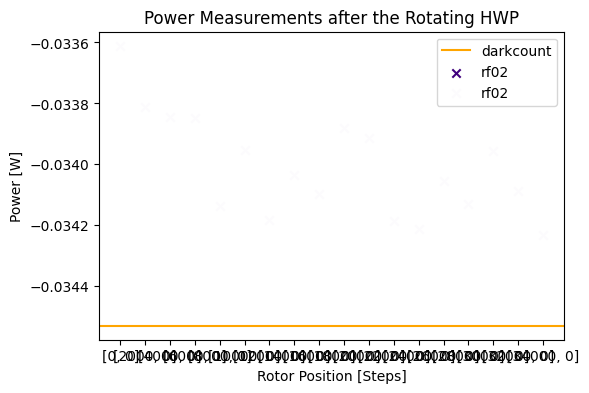

In [17]:
# plot all rfs tgt

fig, ax = plt.subplots(1,1, figsize =  (6,4))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

#darkcount line
ax.axhline(np.average(darkcounts['averaged']), color = 'orange', label = 'darkcount')

for i, data in enumerate(all_rf):
    rf = os.path.basename(csv_files[1]).split('rf')[1][0:2]
    label = f'rf{rf}'
    ax.scatter(data['rotor_step'], data['averaged'], label=label, color = colors[i], marker='x')
    
ax.legend()